In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

### Example $A=Z, B=X$

We want to perform the operation $W = Z + X = \begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}$ which is basically a non-normalized Hadamard
$W |0\rangle = | 0\rangle + |1\rangle$ with $\lambda = 2$

Following the theory, when we measure the ancilla in the state 0, we performed the operation $W/\lambda = 0.5 \begin{pmatrix}
1 & 1 \\
1 & -1
\end{pmatrix}$

In [6]:
prep = QuantumCircuit(1, name="prep")
prep.h(0)

print(prep.draw())

prep = prep.to_instruction()


   ┌───┐
q: ┤ H ├
   └───┘


In [12]:
select = QuantumCircuit(2, name="select")

# 0-control Z gate (target is acted with Z iff control is in 0 state)
select.x(0)
select.cz(0,1)
select.x(0)

# control X gate
select.cx(0,1)


select = select.to_instruction()

In [13]:
q = QuantumRegister(2,'q')
qc = QuantumCircuit(q)

#qc.x(1)  #optional to create an initial state which is |1> 
qc.append(prep, [0])
qc.barrier()

qc.append(select, [0, 1])

qc.barrier()
qc.append(prep.inverse(), [0]) # note the adjoint / dagger (`inverse()`)

In [16]:
print(qc.draw(), "\n\n")

print(qc.decompose().draw())

     ┌──────┐ ░ ┌─────────┐ ░ ┌─────────┐
q_0: ┤ prep ├─░─┤0        ├─░─┤ prep_dg ├
     └──────┘ ░ │  select │ ░ └─────────┘
q_1: ─────────░─┤1        ├─░────────────
              ░ └─────────┘ ░             


     ┌───┐ ░ ┌───┐   ┌───┐      ░ ┌───┐
q_0: ┤ H ├─░─┤ X ├─■─┤ X ├──■───░─┤ H ├
     └───┘ ░ └───┘ │ └───┘┌─┴─┐ ░ └───┘
q_1: ──────░───────■──────┤ X ├─░──────
           ░              └───┘ ░      


Notice that for qiskit the position of the upper qubit (ancilla) is the rightmost,

00 <---- ancilla in0 \
01 \
10 <---- ancilla in0 \
11

In [46]:
psi = Statevector(qc)
print(psi.data)
psi.draw('latex')

[ 0.5+0.j  0.5+0.j  0.5+0.j -0.5+0.j]


<IPython.core.display.Latex object>

In [47]:
qc.measure_all()
print(qc.draw())

        ┌──────┐ ░ ┌─────────┐ ░ ┌─────────┐ ░ ┌─┐   
   q_0: ┤ prep ├─░─┤0        ├─░─┤ prep_dg ├─░─┤M├───
        └──────┘ ░ │  select │ ░ └─────────┘ ░ └╥┘┌─┐
   q_1: ─────────░─┤1        ├─░─────────────░──╫─┤M├
                 ░ └─────────┘ ░             ░  ║ └╥┘
meas: 2/════════════════════════════════════════╩══╩═
                                                0  1 


{'01': 2545, '10': 2566, '11': 2530, '00': 2359}


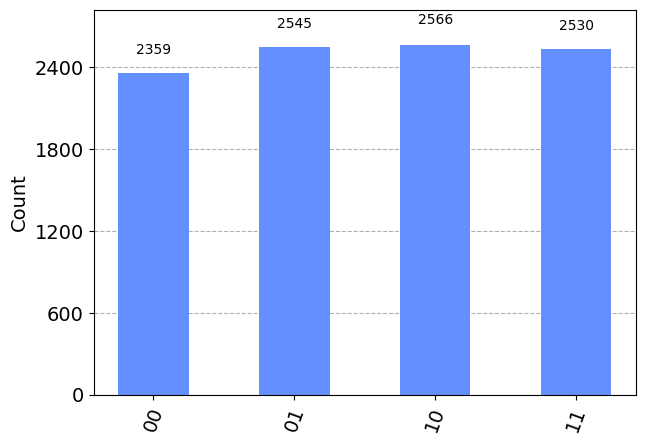

In [49]:
shots = 10000
aer_sim = AerSimulator()

qc = transpile(qc, aer_sim)

result = aer_sim.run(circuits=qc, shots=shots).result()
counts = result.get_counts()

print(counts)
plot_histogram(counts)

In [50]:
print("probability of measuring ancilla in |0> (implementing W |0>):")
print(f"{counts['00']/shots + counts['10']/shots}")

probability of measuring ancilla in |0> (implementing W |0>):
0.4925


We see that there is a probability of 0.5 to mesure the ancilla in $| 0 \rangle$. In that case, the state is left in the superposition $\frac{1}{2}(|0\rangle + |1\rangle) = W |0 \rangle/\lambda$ (with $\lambda = 2$)